# Phase 3 — Addressing Class Imbalance

Multiple strategies:
1. **Class weights** - Simpler, faster, preserves all real data
2. **Moderate SMOTE** - Conservative oversampling for extremely rare classes
3. **Focal Loss** - Advanced loss function for deep learning models

We'll create variants for different model types.

In [1]:
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import joblib
import psutil
import gc
import matplotlib.pyplot as plt
import seaborn as sns

print("Library successfully loaded")

Library successfully loaded


In [4]:
# ===================================================================
# Memory Optimization Utilities
# ===================================================================

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3

def optimize_dtypes(df):
    """Reduce memory usage by optimizing data types"""
    print("\nOptimizing data types...")
    start_mem = df.memory_usage(deep=True).sum() / 1024**3
    print(f"  Initial memory: {start_mem:.2f} GB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**3
    saved = start_mem - end_mem
    print(f"  Final memory: {end_mem:.2f} GB")
    print(f"  Saved: {saved:.2f} GB ({100 * saved / start_mem:.1f}%)")
    
    return df

print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.2f} GB")

System RAM: 15.7 GB
Available RAM: 6.3 GB
Current process memory: 1.92 GB


In [5]:
DATA_DIR = Path("../data")
PROC_DIR = Path("../data/processed/ml_ready")
OUT_DIR = Path("../data/processed/ml_balance")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load standard-scaled training data
print(f"Memory before loading: {get_memory_usage():.2f} GB")
# Load X_train with chunked reading and progress bar
from tqdm import tqdm

file_path = PROC_DIR / "X_train_standard.csv"
file_size = file_path.stat().st_size
chunks = []
chunk_size = 1_000_000  # 1 million rows per chunk

print(f"Loading {file_path.name}...")
with tqdm(total=file_size, unit='B', unit_scale=True, desc="Loading X_train") as pbar:
    for chunk in pd.read_csv(file_path, dtype=np.float32, chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk) * len(chunk.columns) * 4)

X_train = pd.concat(chunks, ignore_index=True)
del chunks
gc.collect()
print(f"Loaded X_train: ({X_train.shape[0]:,} rows, {X_train.shape[1]} columns)")
print(f"Loaded X_train: {X_train.shape}, Memory: {get_memory_usage():.2f} GB")
# Load y_train
y_train = pd.read_csv(PROC_DIR / "y_train.csv", dtype=np.int16)
print(f"Loaded y_train: {len(y_train):,} samples")

# Ensure y_train is a Series
if y_train.shape[1] == 1:
    y_train = y_train.iloc[:, 0]

print("Original train label distribution:\n", y_train.value_counts())
print("\nOriginal distribution:", Counter(y_train))


Memory before loading: 1.92 GB
Loading X_train_standard.csv...


Loading X_train:  33%|███▎      | 5.53G/16.8G [03:41<07:29, 25.0MB/s]


Loaded X_train: (37,349,263 rows, 37 columns)
Loaded X_train: (37349263, 37), Memory: 4.97 GB
Loaded y_train: 37,349,263 samples
Original train label distribution:
 Label_ID
6     5760403
14    4329830
13    3598134
8     3275804
10    3247352
9     3236228
12    2878510
21    2654876
20    2137156
19    1623067
1      878556
23     793493
25     712461
24     601346
7      361991
22     246074
15     229540
4      228083
16     143129
26     107502
27      78607
29      65827
18      57491
32      29906
5       23032
11      18741
17      10451
2        4687
3        4327
30       4196
33       3077
0        2574
28       1810
31       1002
Name: count, dtype: int64

Original distribution: Counter({6: 5760403, 14: 4329830, 13: 3598134, 8: 3275804, 10: 3247352, 9: 3236228, 12: 2878510, 21: 2654876, 20: 2137156, 19: 1623067, 1: 878556, 23: 793493, 25: 712461, 24: 601346, 7: 361991, 22: 246074, 15: 229540, 4: 228083, 16: 143129, 26: 107502, 27: 78607, 29: 65827, 18: 57491, 32: 29906, 5: 

In [ ]:

# Compute Class Weights (for tree-based models)

print("\n=== Computing Class Weights ===")
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: {weight:.4f}")

# Save class weights
joblib.dump(class_weight_dict, OUT_DIR / "class_weights.pkl")
print("Saved class weights to", OUT_DIR / "class_weights.pkl")




=== Computing Class Weights ===
Class weights:
  Class 0: 426.7707
  Class 1: 1.2504
  Class 2: 234.3733
  Class 3: 253.8728
  Class 4: 4.8163
  Class 5: 47.6948
  Class 6: 0.1907
  Class 7: 3.0346
  Class 8: 0.3353
  Class 9: 0.3394
  Class 10: 0.3383
  Class 11: 58.6152
  Class 12: 0.3816
  Class 13: 0.3053
  Class 14: 0.2537
  Class 15: 4.7857
  Class 16: 7.6749
  Class 17: 105.1103
  Class 18: 19.1075
  Class 19: 0.6768
  Class 20: 0.5140
  Class 21: 0.4138
  Class 22: 4.4641
  Class 23: 1.3844
  Class 24: 1.8267
  Class 25: 1.5418
  Class 26: 10.2185
  Class 27: 13.9747
  Class 28: 606.9104
  Class 29: 16.6878
  Class 30: 261.7988
  Class 31: 1096.3151
  Class 32: 36.7320
  Class 33: 357.0061
Saved class weights to ..\data\processed\ml_balance\class_weights.pkl


In [ ]:
# SModerate SMOTE (only for extremely rare classes)
print("\n=== Applying Moderate SMOTE ===")
print(f"Memory before SMOTE: {get_memory_usage():.2f} GB")
# Only boost classes with < 1000 samples to 5000
# Cap BENIGN to reduce dominance
target_distribution = {}
for cls, count in Counter(y_train).items():
    if cls == 0:  # BENIGN
        target_distribution[cls] = min(count, 200_000)
    elif count < 1000:  # Very rare classes
        target_distribution[cls] = 5_000
    elif count < 10_000:  # Moderately rare
        target_distribution[cls] = 10_000
    else:  # Keep as is
        target_distribution[cls] = count

print("Target distribution (moderate approach):", target_distribution)

# Apply moderate resampling
pipeline = Pipeline([
    ("under", RandomUnderSampler(sampling_strategy={0: target_distribution[0]}, random_state=42)),
    ("smote", SMOTE(random_state=42, sampling_strategy=target_distribution, k_neighbors=3))
])

X_res, y_res = pipeline.fit_resample(X_train, y_train)

print("\nAfter moderate resampling:", Counter(y_res))
print(f"Memory after SMOTE: {get_memory_usage():.2f} GB")

pd.DataFrame(X_res, columns=X_train.columns).to_csv(OUT_DIR / "train_balanced.csv", index=False)
pd.Series(y_res).to_csv(OUT_DIR / "train_balanced_labels.csv", index=False)


# Free memory from resampled data
del X_res, y_res
gc.collect()
print(f"Memory after cleanup: {get_memory_usage():.2f} GB")


=== Applying Moderate SMOTE ===
Memory before SMOTE: 5.05 GB
Target distribution (moderate approach): {10: 3247352, 9: 3236228, 14: 4329830, 8: 3275804, 6: 5760403, 12: 2878510, 20: 2137156, 19: 1623067, 21: 2654876, 24: 601346, 25: 712461, 13: 3598134, 1: 878556, 16: 143129, 7: 361991, 27: 78607, 32: 29906, 26: 107502, 4: 228083, 22: 246074, 23: 793493, 15: 229540, 29: 65827, 18: 57491, 5: 23032, 11: 18741, 3: 10000, 2: 10000, 30: 10000, 17: 10451, 31: 10000, 28: 10000, 0: 2574, 33: 10000}

After moderate resampling: Counter({6: 5760403, 14: 4329830, 13: 3598134, 8: 3275804, 10: 3247352, 9: 3236228, 12: 2878510, 21: 2654876, 20: 2137156, 19: 1623067, 1: 878556, 23: 793493, 25: 712461, 24: 601346, 7: 361991, 22: 246074, 15: 229540, 4: 228083, 16: 143129, 26: 107502, 27: 78607, 29: 65827, 18: 57491, 32: 29906, 5: 23032, 11: 18741, 17: 10451, 2: 10000, 3: 10000, 28: 10000, 30: 10000, 31: 10000, 33: 10000, 0: 2574})
Memory after SMOTE: 2.57 GB
Memory after cleanup: 0.17 GB


In [ ]:

#  Save original training data (for class weight approach)
print("=== Saving Original Data (for class weight training) ===")
X_train.to_csv(OUT_DIR / "train_original.csv", index=False)
y_train.to_csv(OUT_DIR / "train_original_labels.csv", index=False)

# Copy over test set - Load with chunked reading
file_path = PROC_DIR / "X_test_standard.csv"
file_size = file_path.stat().st_size
chunks = []
chunk_size = 1_000_000

print(f"Loading {file_path.name}...")
with tqdm(total=file_size, unit='B', unit_scale=True, desc="Loading X_test") as pbar:
    for chunk in pd.read_csv(file_path, dtype=np.float32, chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk) * len(chunk.columns) * 4)

X_test = pd.concat(chunks, ignore_index=True)
del chunks
gc.collect()
print(f"Loaded X_test: {X_test.shape}, Memory: {get_memory_usage():.2f} GB")

# Load y_test
y_test = pd.read_csv(PROC_DIR / "y_test.csv", dtype=np.int16)
print(f"Loaded y_test: {len(y_test):,} samples")
if y_test.shape[1] == 1:
    y_test = y_test.iloc[:, 0]

X_test.to_csv(OUT_DIR / "test.csv", index=False)
y_test.to_csv(OUT_DIR / "test_labels.csv", index=False)

print("Saved all variants:")
print("  - train_original.csv: Use with class_weights")
print("  - train_balanced.csv: Use with moderate SMOTE")
print("  - class_weights.pkl: For tree-based models")
print("  - test.csv: Original test set (never resample!)")

=== Saving Original Data (for class weight training) ===
Loading X_test_standard.csv...


Loading X_test:  33%|███▎      | 1.38G/4.19G [01:11<02:24, 19.4MB/s]


Loaded X_test: (9337316, 37), Memory: 6.72 GB
Loaded y_test: 9,337,316 samples
Saved all variants:
  - train_original.csv: Use with class_weights
  - train_balanced.csv: Use with moderate SMOTE
  - class_weights.pkl: For tree-based models
  - test.csv: Original test set (never resample!)


In [ ]:
# Create Focal Loss for Deep Learning
focal_loss_code = '''
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss for multi-class classification
    
    Args:
        gamma: Focusing parameter (default 2.0)
        alpha: Balancing parameter (default 0.25)
    
    Returns:
        Loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Compute cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Compute focal loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        
        return K.mean(K.sum(loss, axis=-1))
    
    return focal_loss_fixed

# Usage in model compilation:
# model.compile(optimizer='adam', loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
'''

with open(OUT_DIR / "focal_loss.py", "w") as f:
    f.write(focal_loss_code)

print("Saved focal_loss.py for deep learning models")
print("\nRecommendations:")
print("  • Tree models (RF/XGB): Use train_original.csv + class_weights")
print("  • Deep Learning: Use train_original.csv + focal_loss.py")
print("  • Baseline comparison: Use train_balanced.csv")


=== Creating Focal Loss Implementation ===
Saved focal_loss.py for deep learning models

Recommendations:
  • Tree models (RF/XGB): Use train_original.csv + class_weights
  • Deep Learning: Use train_original.csv + focal_loss.py
  • Baseline comparison: Use train_balanced.csv


Loading balanced labels for visualization...
Loaded y_res: 37,390,164 samples


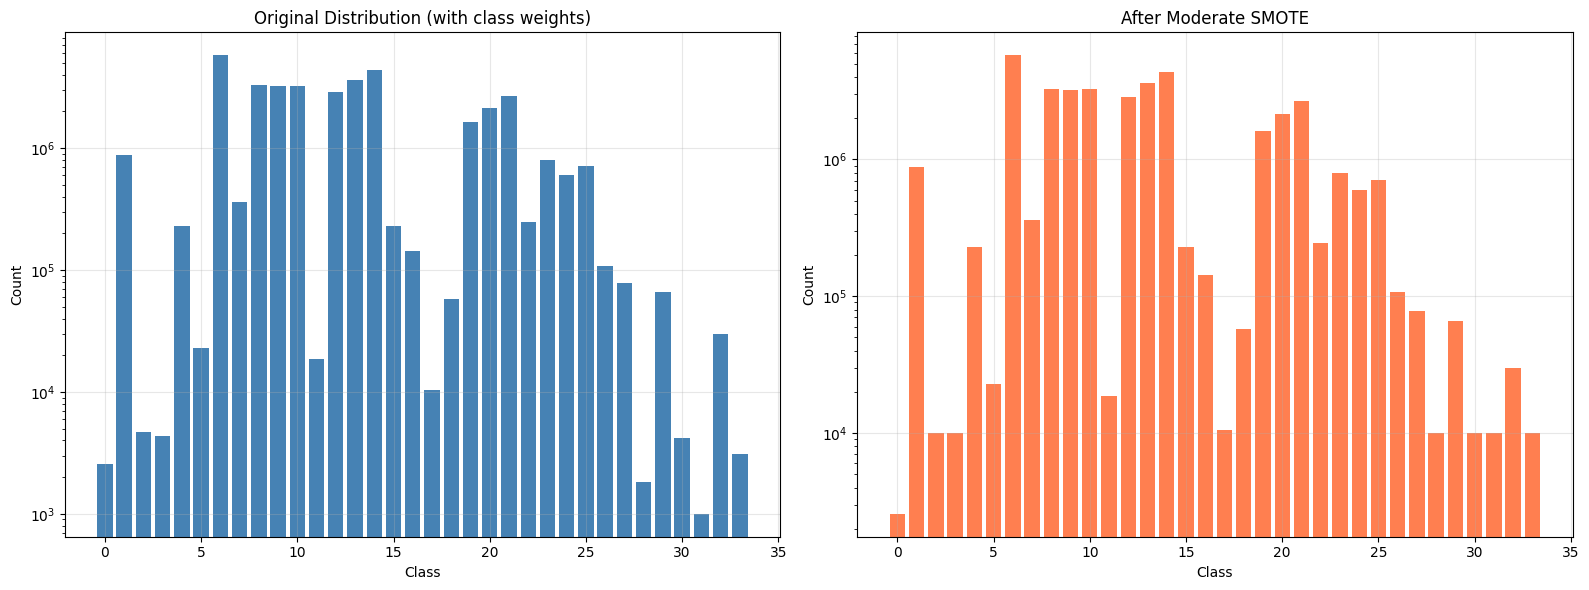


Summary:
Original samples: 37,349,263
After SMOTE: 37,390,164
Size increase: 0.1%


15572

In [12]:
# Visualization: Compare distributions

# Load the balanced labels that were saved earlier
print("Loading balanced labels for visualization...")
y_res = pd.read_csv(OUT_DIR / "train_balanced_labels.csv", dtype=np.int16)
if y_res.shape[1] == 1:
    y_res = y_res.iloc[:, 0]
print(f"Loaded y_res: {len(y_res):,} samples")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
y_train_counts = y_train.value_counts().sort_index()
axes[0].bar(y_train_counts.index, y_train_counts.values, color='steelblue')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Original Distribution (with class weights)')
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# After moderate SMOTE
y_res_counts = pd.Series(y_res).value_counts().sort_index()
axes[1].bar(y_res_counts.index, y_res_counts.values, color='coral')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('After Moderate SMOTE')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSummary:")
print(f"Original samples: {len(y_train):,}")
print(f"After SMOTE: {len(y_res):,}")
print(f"Size increase: {(len(y_res) / len(y_train) - 1) * 100:.1f}%")

# Clean up
del y_res
gc.collect()